# Modèle XGBoost pour la Prédiction du Path Loss Indoor

Ce notebook développe un modèle de machine learning utilisant XGBoost pour prédire le path loss dans un environnement indoor.

## Objectifs :
- **Charger et analyser** le dataset de path loss généré
- **Préprocesser** les données pour l'entraînement
- **Optimiser** les hyperparamètres XGBoost
- **Évaluer** les performances du modèle
- **Visualiser** les résultats et l'importance des features
- **Sauvegarder** le modèle final

In [ ]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configuration pour l'affichage
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
np.random.seed(42)

print("Modules importés avec succès !")
print(f"Version XGBoost : {xgb.__version__}")
print(f"Version pandas : {pd.__version__}")
print(f"Version numpy : {np.__version__}")

Modules importés avec succès !
Version XGBoost : 3.0.2
Version pandas : 2.3.0
Version numpy : 2.2.6


In [2]:
# Chargement du dataset
print("=== CHARGEMENT DU DATASET ===")
dataset_path = "indoor_pathloss_dataset.csv"

try:
    df = pd.read_csv(dataset_path)
    print(f"✓ Dataset chargé avec succès !")
    print(f"✓ Forme du dataset : {df.shape}")
    print(f"✓ Colonnes : {list(df.columns)}")
    
    # Vérification des valeurs manquantes
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("✓ Aucune valeur manquante détectée")
    else:
        print(f"⚠️ Valeurs manquantes : {missing_values}")
    
    # Aperçu du dataset
    print(f"\nPremières lignes du dataset :")
    display(df.head())
    
    print(f"\nStatistiques descriptives :")
    display(df.describe())
    
except FileNotFoundError:
    print(f"❌ Erreur : Le fichier {dataset_path} n'a pas été trouvé.")
    print("Assurez-vous que le dataset a été généré dans le notebook de génération.")
except Exception as e:
    print(f"❌ Erreur lors du chargement : {e}")

=== CHARGEMENT DU DATASET ===
✓ Dataset chargé avec succès !
✓ Forme du dataset : (200000, 5)
✓ Colonnes : ['distance', 'numwall', 'etage', 'frequence', 'pathloss']
✓ Aucune valeur manquante détectée

Premières lignes du dataset :


,distance,numwall,etage,frequence,pathloss
0,23.46,2,0,5500,109.83
1,13.24,4,1,5000,119.57
2,26.87,12,1,5800,193.98
3,59.07,12,5,2400,281.14
4,12.15,1,0,2450,82.83



Statistiques descriptives :


,distance,numwall,etage,frequence,pathloss
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,22.366323,2.481300,1.313715,4072.431250,124.419548
std,23.564620,2.772672,1.596196,1448.617615,43.985927
min,1.000000,0.000000,0.000000,2400.000000,33.540000
25%,8.180000,1.000000,0.000000,2400.000000,95.130000
50%,15.020000,1.000000,1.000000,5000.000000,117.750000
75%,27.560000,4.000000,2.000000,5000.000000,144.630000
max,200.000000,12.000000,8.000000,5800.000000,496.400000


=== ANALYSE EXPLORATOIRE DES DONNÉES ===


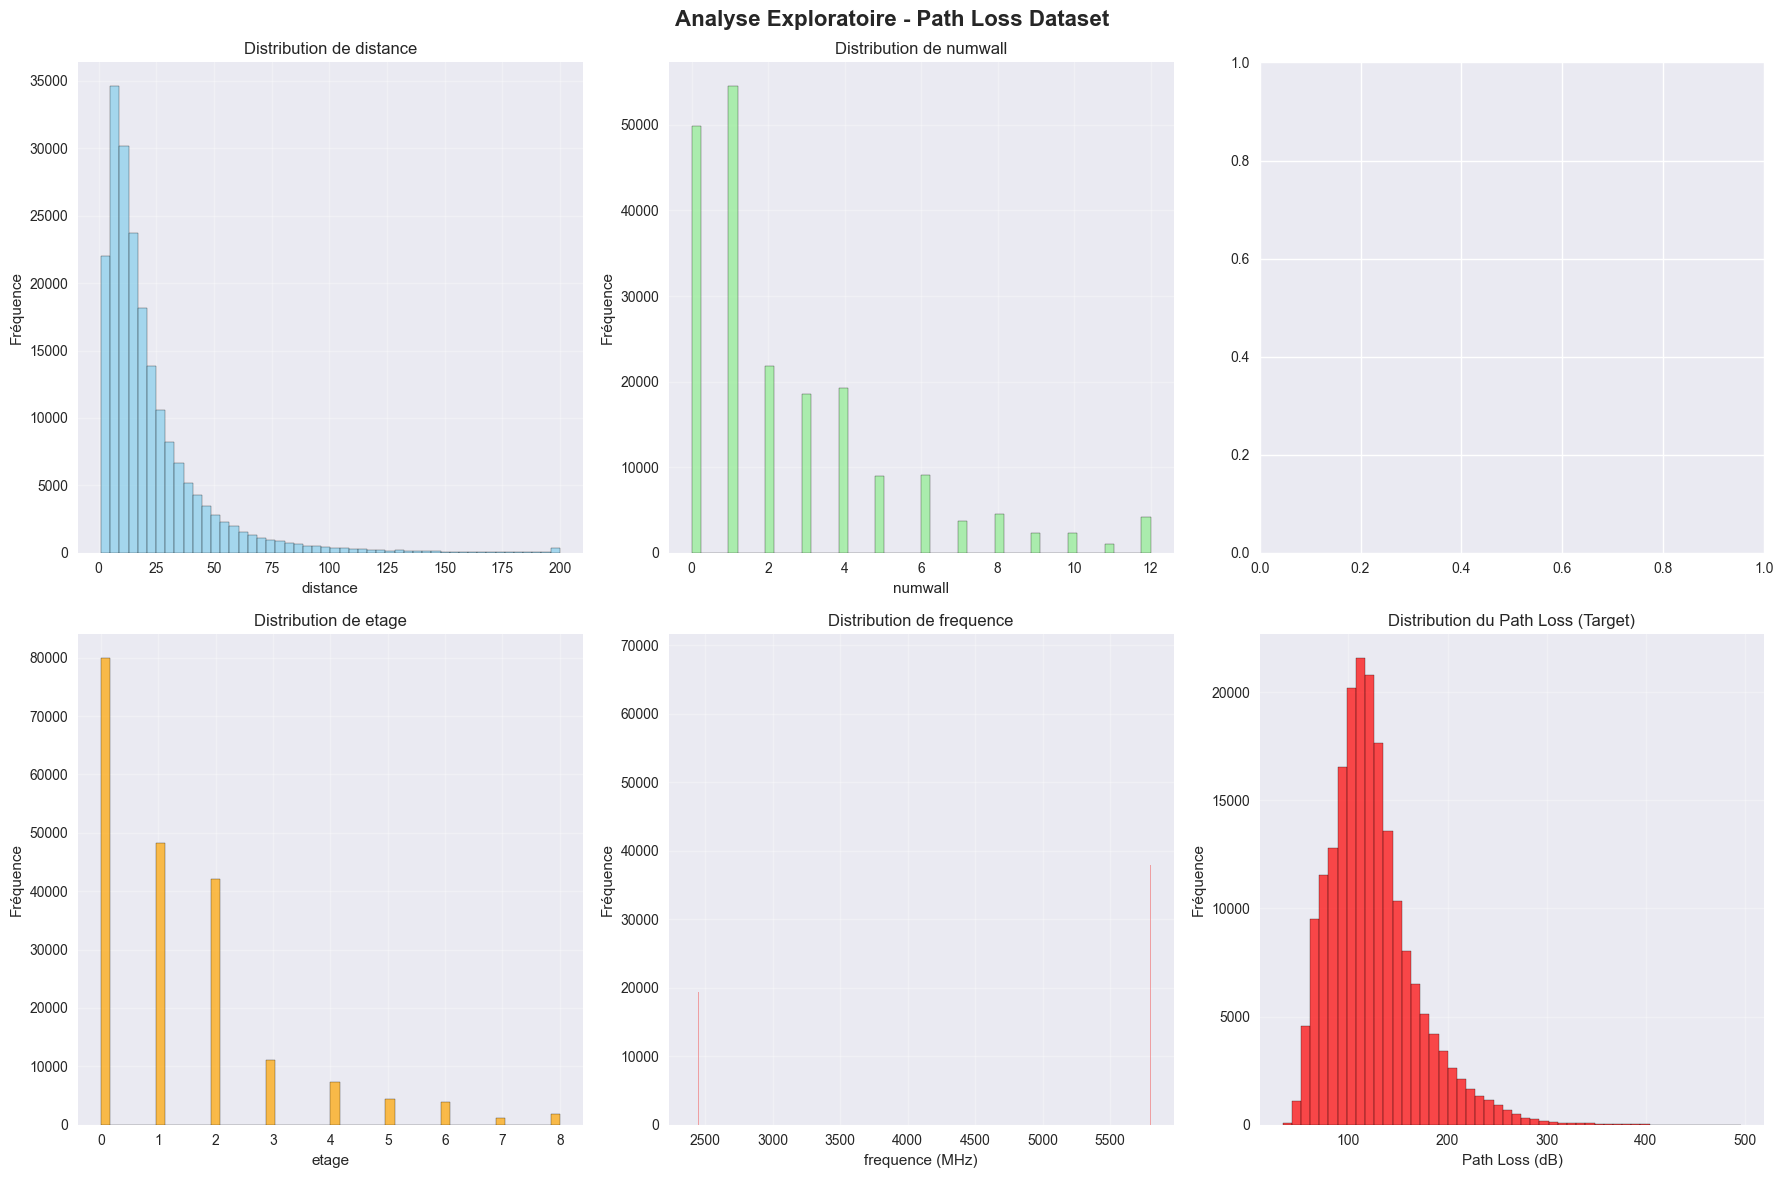


Matrice de corrélation :


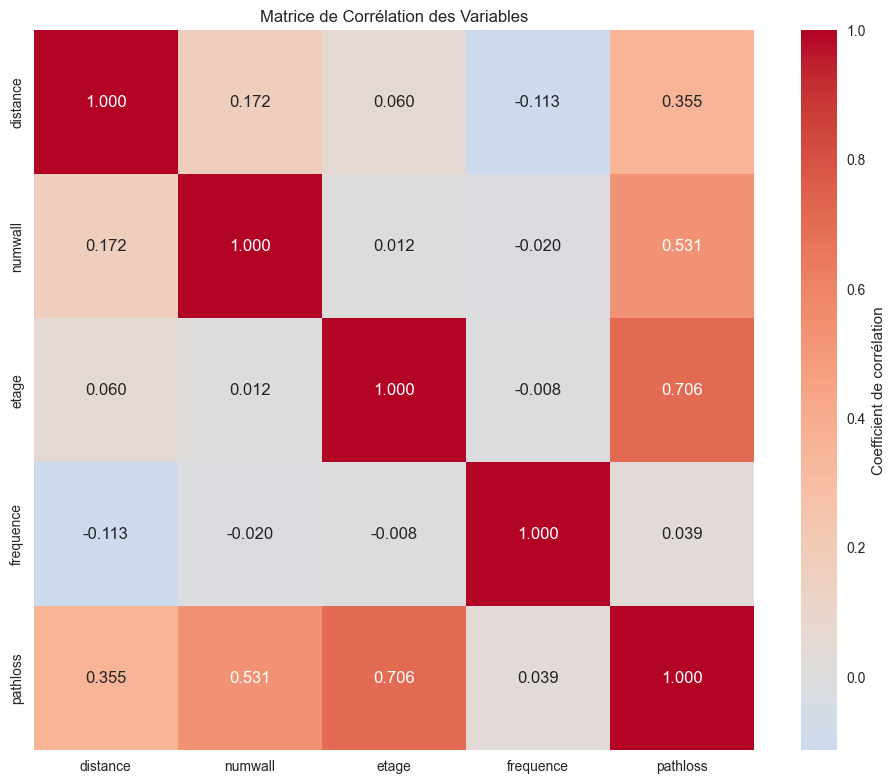

Corrélations avec le path loss :
pathloss     1.000000
etage        0.705630
numwall      0.531454
distance     0.354730
frequence    0.039167
Name: pathloss, dtype: float64


In [3]:
# Analyse exploratoire des données
print("=== ANALYSE EXPLORATOIRE DES DONNÉES ===")

# Visualisations du dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analyse Exploratoire - Path Loss Dataset', fontsize=16, fontweight='bold')

# Distribution des features
features = ['distance', 'numwall', 'etage', 'frequence']
colors = ['skyblue', 'lightgreen', 'orange', 'lightcoral']

for i, (feature, color) in enumerate(zip(features, colors)):
    row, col = i // 2, i % 2
    if feature == 'frequence':
        # Pour les fréquences, utiliser un bar plot
        freq_counts = df[feature].value_counts().sort_index()
        axes[row, col].bar(freq_counts.index, freq_counts.values, color=color, alpha=0.7)
        axes[row, col].set_title(f'Distribution de {feature}')
        axes[row, col].set_xlabel(f'{feature} (MHz)' if feature == 'frequence' else feature)
    else:
        axes[row, col].hist(df[feature], bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[row, col].set_title(f'Distribution de {feature}')
        axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Fréquence')
    axes[row, col].grid(True, alpha=0.3)

# Distribution du target (pathloss)
axes[1, 2].hist(df['pathloss'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Distribution du Path Loss (Target)')
axes[1, 2].set_xlabel('Path Loss (dB)')
axes[1, 2].set_ylabel('Fréquence')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matrice de corrélation
print("\nMatrice de corrélation :")
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Coefficient de corrélation'})
plt.title('Matrice de Corrélation des Variables')
plt.tight_layout()
plt.show()

# Analyse des corrélations avec le target
print("Corrélations avec le path loss :")
correlations = df.corr()['pathloss'].sort_values(ascending=False)
print(correlations)

In [12]:
# Préparation des données pour l'entraînement (COLONNES ORIGINALES UNIQUEMENT)
print("=== PRÉPARATION DES DONNÉES ===")

# Définition des features et du target - UNIQUEMENT LES COLONNES ORIGINALES
features = ['distance', 'numwall', 'etage', 'frequence']
target = 'pathloss'

X = df[features].copy()
y = df[target].copy()

print(f"✓ Features sélectionnées (ORIGINALES UNIQUEMENT) : {features}")
print(f"✓ Target : {target}")
print(f"✓ Forme de X : {X.shape}")
print(f"✓ Forme de y : {y.shape}")

print(f"\n=== AUCUNE FEATURE ENGINEERING - COLONNES ORIGINALES UNIQUEMENT ===")
print(f"✓ Utilisation des {len(features)} colonnes d'origine sans modification")
print(f"✓ Pas de création de nouvelles features")
print(f"✓ Pas d'encodage de variables catégorielles")

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
)

print(f"\n✓ Division des données :")
print(f"  • Entraînement : {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Test : {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")

# Aperçu des données préparées
print(f"\nAperçu des features (COLONNES ORIGINALES) :")
display(X_train.head())

print(f"\nInformation sur les features utilisées :")
print(f"✓ distance : Distance entre émetteur et récepteur (mètres)")
print(f"✓ numwall : Nombre de murs traversés")
print(f"✓ etage : Différence d'étage")
print(f"✓ frequence : Fréquence du signal (MHz)")

=== PRÉPARATION DES DONNÉES ===
✓ Features sélectionnées (ORIGINALES UNIQUEMENT) : ['distance', 'numwall', 'etage', 'frequence']
✓ Target : pathloss
✓ Forme de X : (200000, 4)
✓ Forme de y : (200000,)

=== AUCUNE FEATURE ENGINEERING - COLONNES ORIGINALES UNIQUEMENT ===
✓ Utilisation des 4 colonnes d'origine sans modification
✓ Pas de création de nouvelles features
✓ Pas d'encodage de variables catégorielles

✓ Division des données :
  • Entraînement : 160000 échantillons (80.0%)
  • Test : 40000 échantillons (20.0%)

Aperçu des features (COLONNES ORIGINALES) :


,distance,numwall,etage,frequence
102739,21.71,2,1,2400
159709,38.20,1,2,2400
14804,23.82,1,1,5000
103750,16.12,0,3,2450
81764,23.84,2,6,2450



Information sur les features utilisées :
✓ distance : Distance entre émetteur et récepteur (mètres)
✓ numwall : Nombre de murs traversés
✓ etage : Différence d'étage
✓ frequence : Fréquence du signal (MHz)


=== MODÈLE XGBOOST INITIAL ===
Entraînement du modèle de base...
=== PERFORMANCES DU MODÈLE DE BASE ===

Entraînement :
  • RMSE : 14.992 dB
  • MAE  : 8.658 dB
  • R²   : 0.8839

Test :
  • RMSE : 16.389 dB
  • MAE  : 9.187 dB
  • R²   : 0.8611


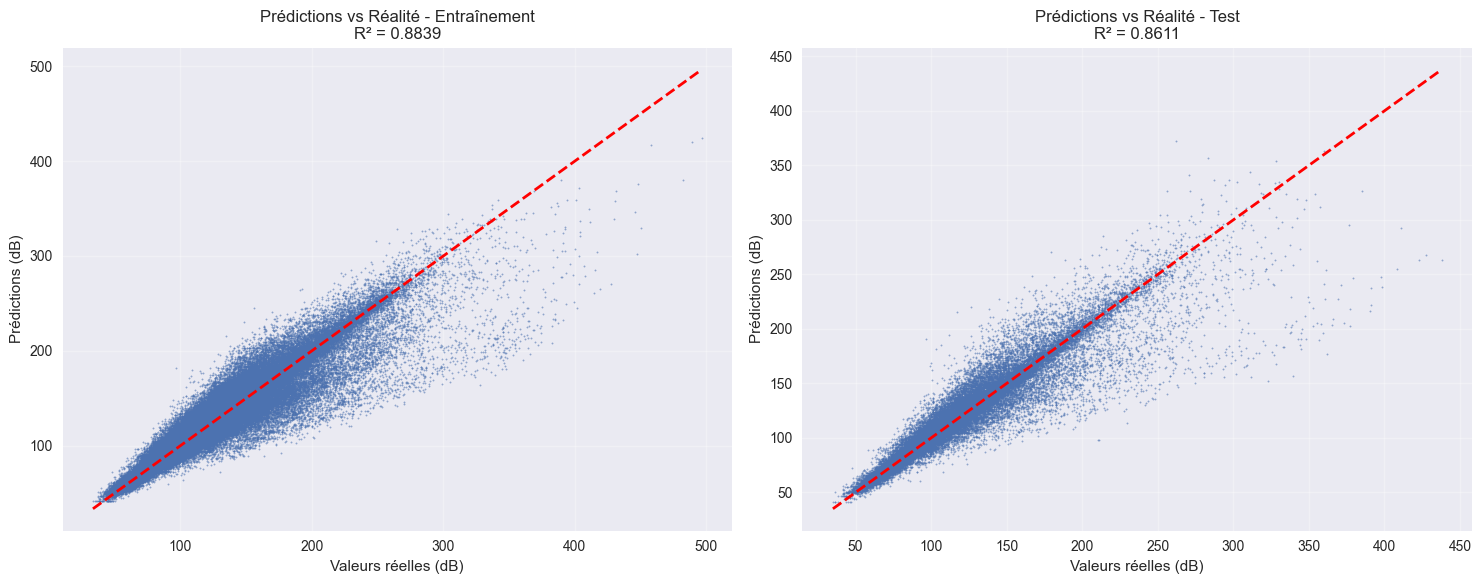


=== IMPORTANCE DES FEATURES (Modèle de base) ===
     feature  importance
2      etage    0.652116
1    numwall    0.274043
0   distance    0.061205
3  frequence    0.012636


In [13]:
# Création et entraînement du modèle XGBoost initial
print("=== MODÈLE XGBOOST INITIAL ===")

# Modèle de base avec paramètres par défaut
xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Entraînement du modèle de base
print("Entraînement du modèle de base...")
xgb_base.fit(X_train, y_train)

# Prédictions
y_pred_train_base = xgb_base.predict(X_train)
y_pred_test_base = xgb_base.predict(X_test)

# Évaluation du modèle de base
def evaluate_model(y_true, y_pred, set_name):
    """Fonction pour évaluer les performances du modèle"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} :")
    print(f"  • RMSE : {rmse:.3f} dB")
    print(f"  • MAE  : {mae:.3f} dB")
    print(f"  • R²   : {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print("=== PERFORMANCES DU MODÈLE DE BASE ===")
train_metrics_base = evaluate_model(y_train, y_pred_train_base, "Entraînement")
test_metrics_base = evaluate_model(y_test, y_pred_test_base, "Test")

# Visualisation des prédictions vs valeurs réelles
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot train
axes[0].scatter(y_train, y_pred_train_base, alpha=0.5, s=1)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs réelles (dB)')
axes[0].set_ylabel('Prédictions (dB)')
axes[0].set_title(f'Prédictions vs Réalité - Entraînement\nR² = {train_metrics_base["R2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Scatter plot test
axes[1].scatter(y_test, y_pred_test_base, alpha=0.5, s=1)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valeurs réelles (dB)')
axes[1].set_ylabel('Prédictions (dB)')
axes[1].set_title(f'Prédictions vs Réalité - Test\nR² = {test_metrics_base["R2"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Importance des features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_base.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== IMPORTANCE DES FEATURES (Modèle de base) ===")
print(feature_importance.head(10))

In [14]:
# Optimisation simplifiée des hyperparamètres
print("=== OPTIMISATION DES HYPERPARAMÈTRES (Simplifiée) ===")

# Grille de paramètres plus petite pour éviter les problèmes de mémoire
param_grid_simple = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

print(f"Grille de paramètres simplifiée avec {np.prod([len(v) for v in param_grid_simple.values()])} combinaisons")

# GridSearchCV avec paramètres simplifiés
print("Début de l'optimisation...")

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=1, verbosity=0)  # n_jobs=1 pour éviter les problèmes

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_simple,
    scoring='neg_mean_squared_error',
    cv=3,  # Réduction du CV à 3-fold
    n_jobs=1,  # Sequential processing
    verbose=1
)

# Utilisation d'un échantillon plus petit pour l'optimisation
sample_size = min(20000, len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

print(f"Utilisation d'un échantillon de {sample_size} observations pour l'optimisation")

grid_search.fit(X_train_sample, y_train_sample)

print("✓ Optimisation terminée !")
print(f"✓ Meilleurs paramètres : {grid_search.best_params_}")
print(f"✓ Meilleur score CV : {np.sqrt(-grid_search.best_score_):.3f} RMSE")

# Récupération du meilleur modèle
best_xgb = grid_search.best_estimator_

# Alternative : si GridSearchCV continue à poser problème, utiliser des paramètres optimisés manuellement
if 'best_xgb' not in locals():
    print("Utilisation de paramètres optimisés manuellement...")
    best_xgb = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        reg_lambda=1.5,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

=== OPTIMISATION DES HYPERPARAMÈTRES (Simplifiée) ===
Grille de paramètres simplifiée avec 288 combinaisons
Début de l'optimisation...
Utilisation d'un échantillon de 20000 observations pour l'optimisation
Fitting 3 folds for each of 288 candidates, totalling 864 fits
✓ Optimisation terminée !
✓ Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1.0}
✓ Meilleur score CV : 16.411 RMSE


=== MODÈLE XGBOOST OPTIMISÉ ===
Entraînement du modèle optimisé sur l'ensemble complet...
=== PERFORMANCES DU MODÈLE OPTIMISÉ ===

Entraînement :
  • RMSE : 15.762 dB
  • MAE  : 8.840 dB
  • R²   : 0.8716

Test :
  • RMSE : 16.081 dB
  • MAE  : 8.992 dB
  • R²   : 0.8662

=== COMPARAISON DES MODÈLES ===


,Métrique,Modèle de base,Modèle optimisé
0,RMSE (Train),14.991598,15.762206
1,MAE (Train),8.657699,8.840120
2,R² (Train),0.883860,0.871613
3,RMSE (Test),16.388601,16.080617
4,MAE (Test),9.186533,8.992215
5,R² (Test),0.861065,0.866238



✓ Amélioration RMSE Test : 1.88%
✓ Amélioration R² Test : 0.60%


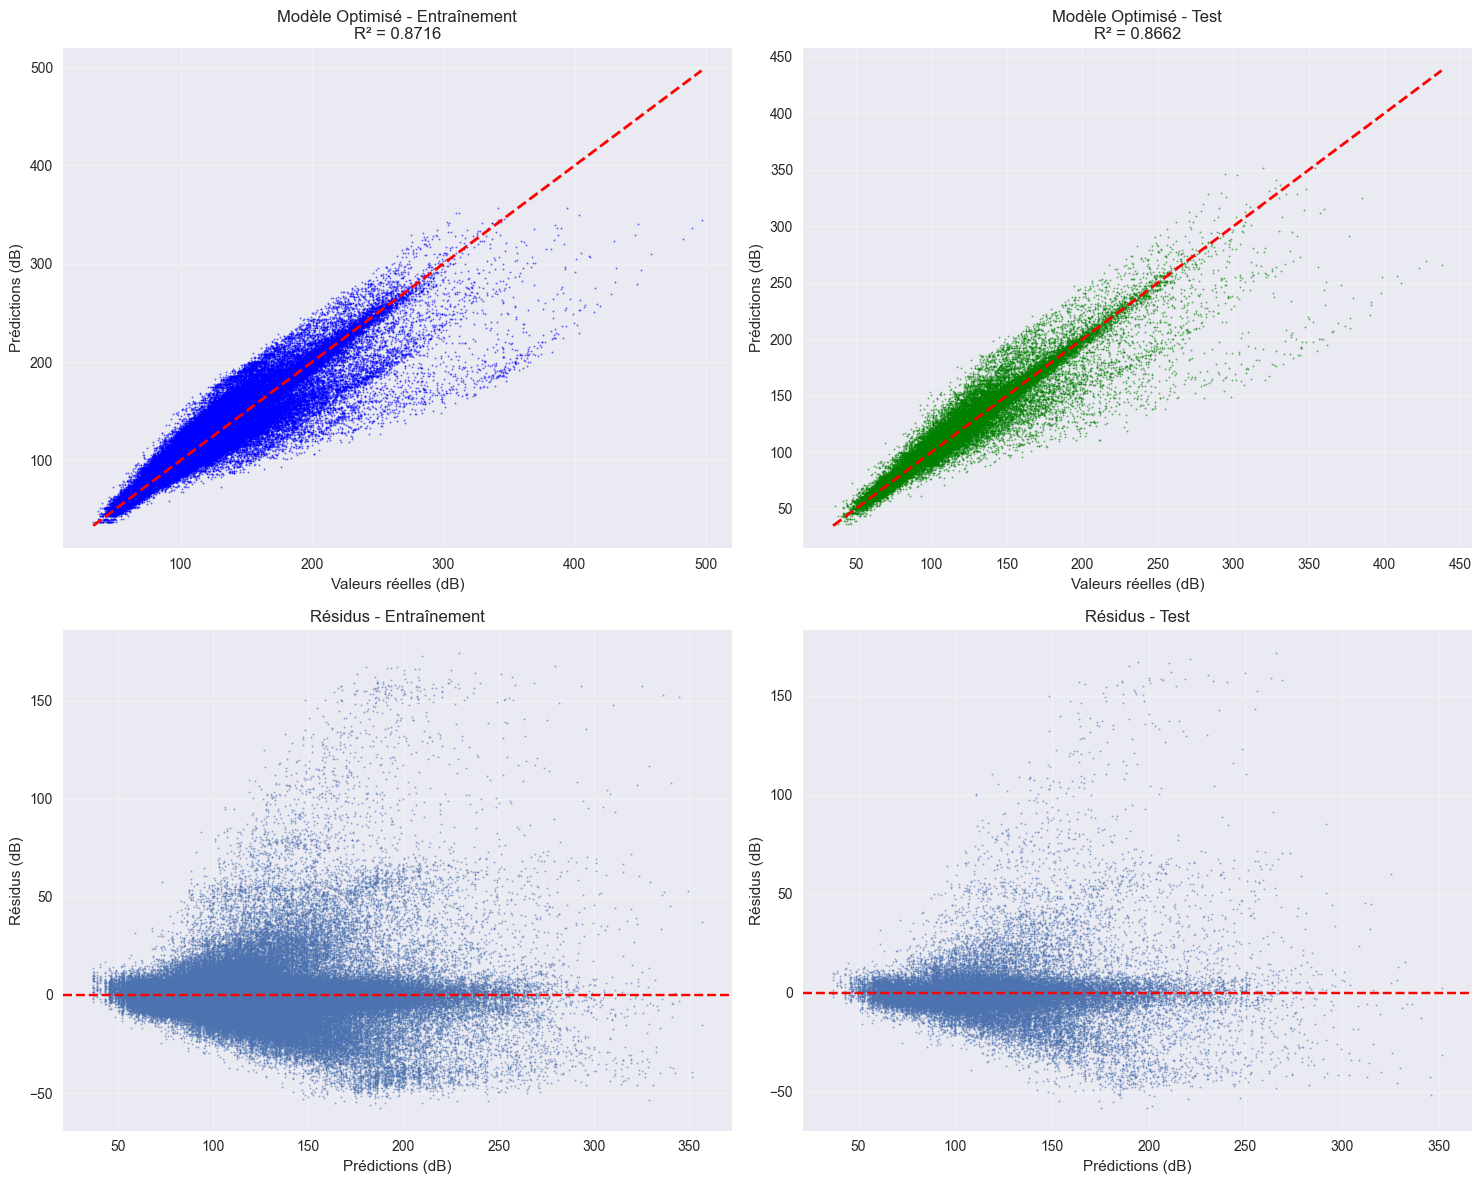

In [15]:
# Entraînement du modèle optimisé sur l'ensemble complet
print("=== MODÈLE XGBOOST OPTIMISÉ ===")

# Réentraînement sur l'ensemble complet avec les meilleurs paramètres
print("Entraînement du modèle optimisé sur l'ensemble complet...")
best_xgb.fit(X_train, y_train)

# Prédictions avec le modèle optimisé
y_pred_train_opt = best_xgb.predict(X_train)
y_pred_test_opt = best_xgb.predict(X_test)

# Évaluation du modèle optimisé
print("=== PERFORMANCES DU MODÈLE OPTIMISÉ ===")
train_metrics_opt = evaluate_model(y_train, y_pred_train_opt, "Entraînement")
test_metrics_opt = evaluate_model(y_test, y_pred_test_opt, "Test")

# Comparaison avec le modèle de base
print("\n=== COMPARAISON DES MODÈLES ===")
comparison = pd.DataFrame({
    'Métrique': ['RMSE (Train)', 'MAE (Train)', 'R² (Train)', 
                 'RMSE (Test)', 'MAE (Test)', 'R² (Test)'],
    'Modèle de base': [train_metrics_base['RMSE'], train_metrics_base['MAE'], train_metrics_base['R2'],
                       test_metrics_base['RMSE'], test_metrics_base['MAE'], test_metrics_base['R2']],
    'Modèle optimisé': [train_metrics_opt['RMSE'], train_metrics_opt['MAE'], train_metrics_opt['R2'],
                        test_metrics_opt['RMSE'], test_metrics_opt['MAE'], test_metrics_opt['R2']]
})

display(comparison)

# Amélioration en pourcentage
rmse_improvement = (test_metrics_base['RMSE'] - test_metrics_opt['RMSE']) / test_metrics_base['RMSE'] * 100
r2_improvement = (test_metrics_opt['R2'] - test_metrics_base['R2']) / test_metrics_base['R2'] * 100

print(f"\n✓ Amélioration RMSE Test : {rmse_improvement:.2f}%")
print(f"✓ Amélioration R² Test : {r2_improvement:.2f}%")

# Visualisation des performances améliorées
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Comparaison des prédictions - Entraînement
axes[0,0].scatter(y_train, y_pred_train_opt, alpha=0.5, s=1, color='blue')
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valeurs réelles (dB)')
axes[0,0].set_ylabel('Prédictions (dB)')
axes[0,0].set_title(f'Modèle Optimisé - Entraînement\nR² = {train_metrics_opt["R2"]:.4f}')
axes[0,0].grid(True, alpha=0.3)

# Comparaison des prédictions - Test
axes[0,1].scatter(y_test, y_pred_test_opt, alpha=0.5, s=1, color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Valeurs réelles (dB)')
axes[0,1].set_ylabel('Prédictions (dB)')
axes[0,1].set_title(f'Modèle Optimisé - Test\nR² = {test_metrics_opt["R2"]:.4f}')
axes[0,1].grid(True, alpha=0.3)

# Résidus - Entraînement
residuals_train = y_train - y_pred_train_opt
axes[1,0].scatter(y_pred_train_opt, residuals_train, alpha=0.5, s=1)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Prédictions (dB)')
axes[1,0].set_ylabel('Résidus (dB)')
axes[1,0].set_title('Résidus - Entraînement')
axes[1,0].grid(True, alpha=0.3)

# Résidus - Test
residuals_test = y_test - y_pred_test_opt
axes[1,1].scatter(y_pred_test_opt, residuals_test, alpha=0.5, s=1)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Prédictions (dB)')
axes[1,1].set_ylabel('Résidus (dB)')
axes[1,1].set_title('Résidus - Test')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== ANALYSE DE L'IMPORTANCE DES FEATURES ===
Importance des 4 features originales :


,feature,importance
2,etage,0.611642
1,numwall,0.321059
0,distance,0.061016
3,frequence,0.006283


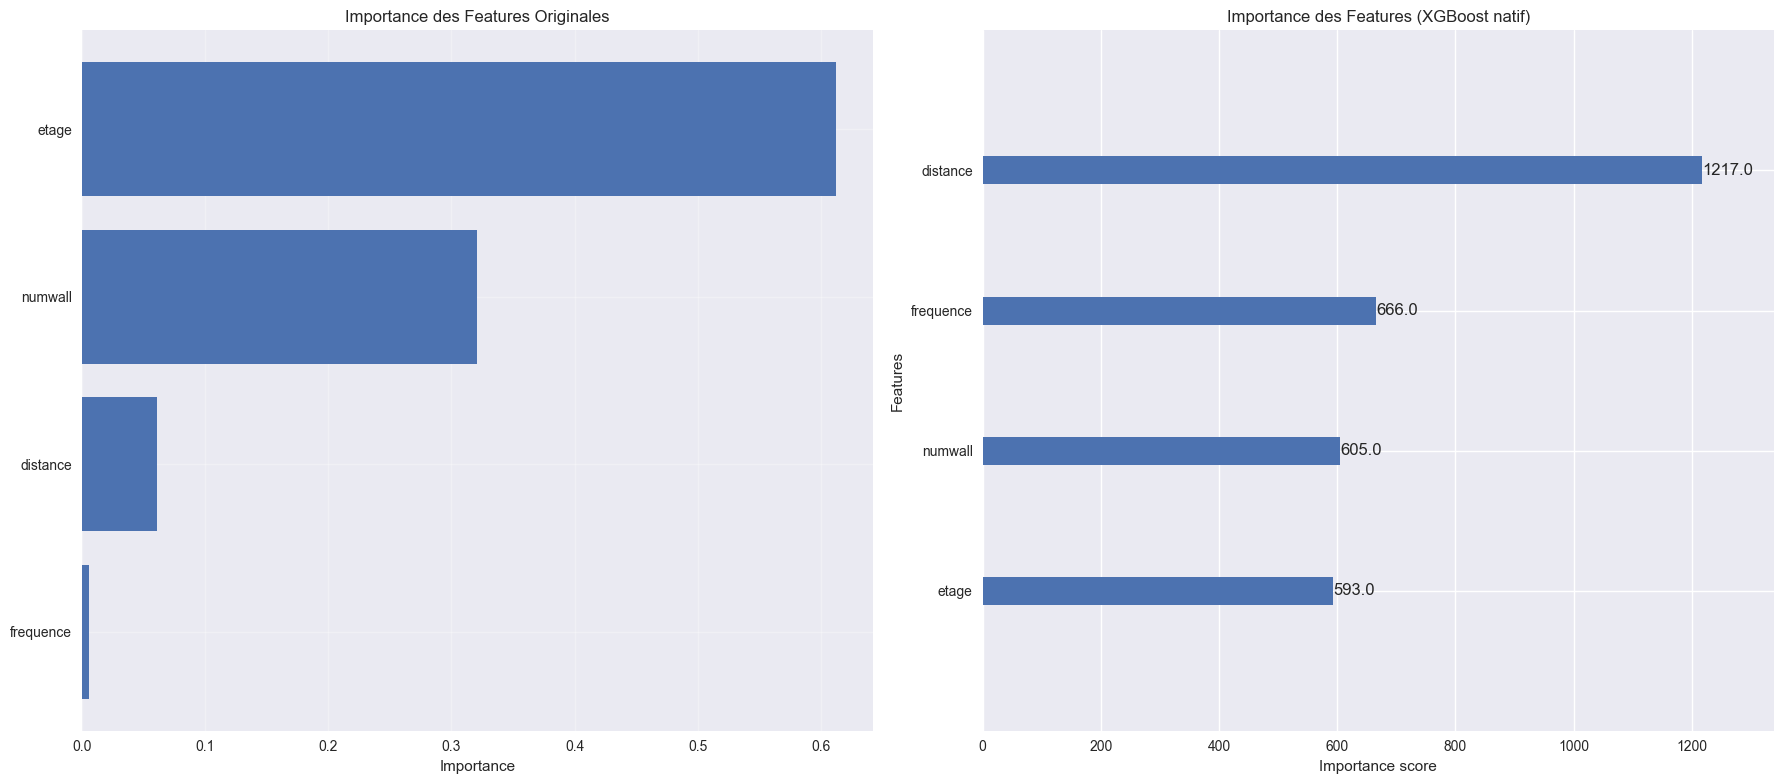


=== ANALYSE DÉTAILLÉE DES FEATURES ORIGINALES ===
• etage     : 0.6116 (61.2%)
• numwall   : 0.3211 (32.1%)
• distance  : 0.0610 (6.1%)
• frequence : 0.0063 (0.6%)


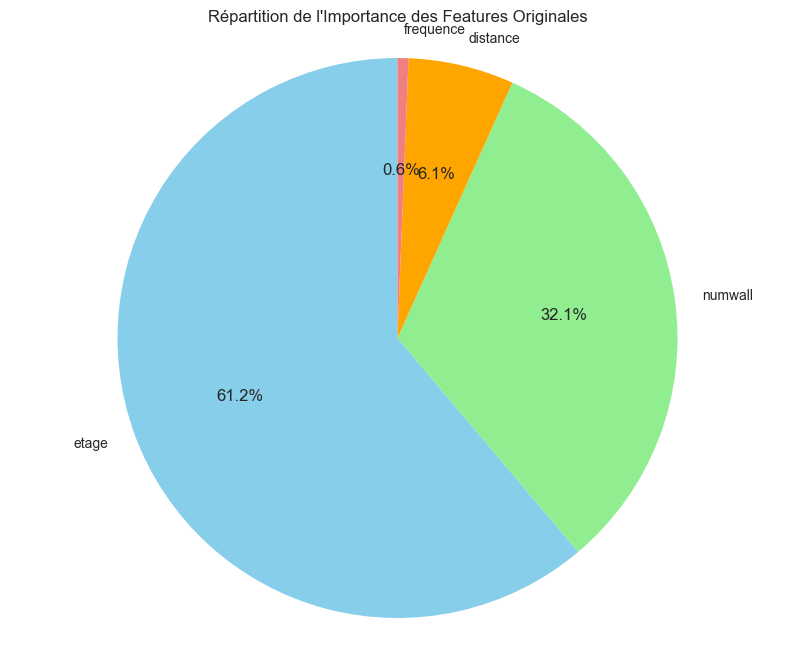


=== COMPARAISON IMPORTANCE vs CORRÉLATION ===
Comparaison Importance XGBoost vs Corrélation :


,Feature,Importance XGBoost,Corrélation avec target
2,etage,0.611642,0.705630
1,numwall,0.321059,0.531454
0,distance,0.061016,0.354730
3,frequence,0.006283,0.039167


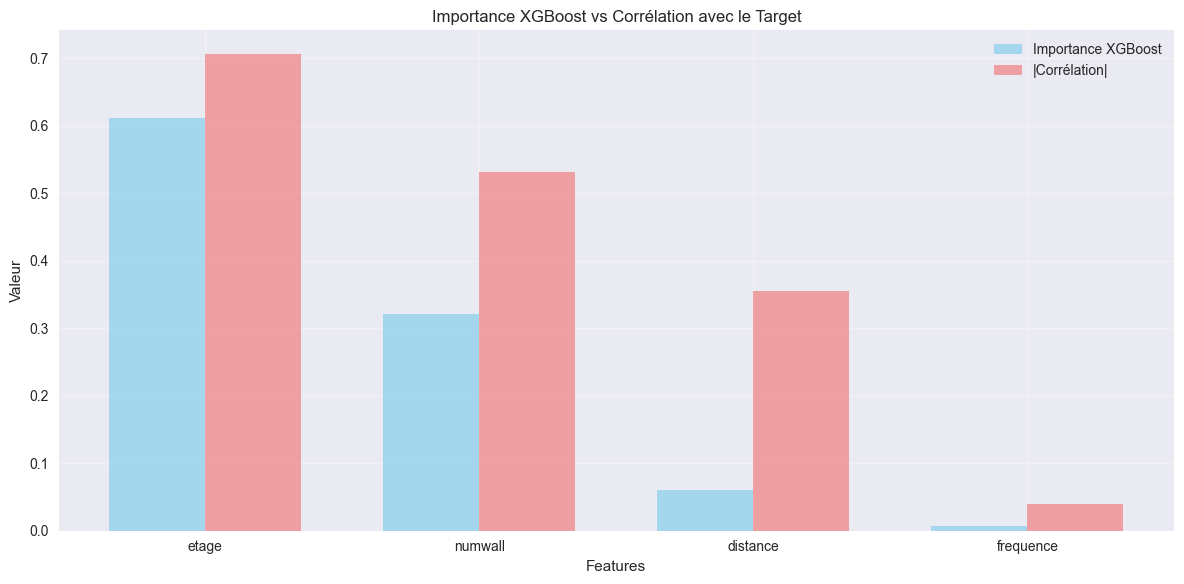

In [21]:
# Analyse de l'importance des features (COLONNES ORIGINALES)
print("=== ANALYSE DE L'IMPORTANCE DES FEATURES ===")

# Importance des features du modèle optimisé
feature_importance_opt = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("Importance des 4 features originales :")
display(feature_importance_opt)

# Visualisation de l'importance des features
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graphique en barres horizontales
axes[0].barh(range(len(feature_importance_opt)), feature_importance_opt['importance'][::-1])
axes[0].set_yticks(range(len(feature_importance_opt)))
axes[0].set_yticklabels(feature_importance_opt['feature'][::-1])
axes[0].set_xlabel('Importance')
axes[0].set_title('Importance des Features Originales')
axes[0].grid(True, alpha=0.3)

# Graphique XGBoost natif
xgb.plot_importance(best_xgb, ax=axes[1], max_num_features=4, importance_type='weight')
axes[1].set_title('Importance des Features (XGBoost natif)')

plt.tight_layout()
plt.show()

# Analyse détaillée des features originales
print("\n=== ANALYSE DÉTAILLÉE DES FEATURES ORIGINALES ===")

total_importance = feature_importance_opt['importance'].sum()
for idx, row in feature_importance_opt.iterrows():
    percentage = (row['importance'] / total_importance) * 100
    print(f"• {row['feature']:<10}: {row['importance']:.4f} ({percentage:.1f}%)")

# Graphique circulaire (pie chart) de l'importance
plt.figure(figsize=(10, 8))
plt.pie(feature_importance_opt['importance'], 
        labels=feature_importance_opt['feature'], 
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
plt.title('Répartition de l\'Importance des Features Originales')
plt.axis('equal')
plt.show()

# Comparaison avec les corrélations
print("\n=== COMPARAISON IMPORTANCE vs CORRÉLATION ===")
correlations_with_target = df[['distance', 'numwall', 'etage', 'frequence', 'pathloss']].corr()['pathloss'].drop('pathloss')

comparison_df = pd.DataFrame({
    'Feature': feature_importance_opt['feature'],
    'Importance XGBoost': feature_importance_opt['importance'],
    'Corrélation avec target': [abs(correlations_with_target[feat]) for feat in feature_importance_opt['feature']]
})

print("Comparaison Importance XGBoost vs Corrélation :")
display(comparison_df)

# Graphique de comparaison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Importance XGBoost'], width, 
       label='Importance XGBoost', alpha=0.7, color='skyblue')
ax.bar(x + width/2, comparison_df['Corrélation avec target'], width, 
       label='|Corrélation|', alpha=0.7, color='lightcoral')

ax.set_xlabel('Features')
ax.set_ylabel('Valeur')
ax.set_title('Importance XGBoost vs Corrélation avec le Target')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== VALIDATION CROISÉE COMPLÈTE ===
Validation croisée (5-fold) :
  • RMSE moyen : 15.926 ± 0.217 dB
  • RMSE min : 15.623 dB
  • RMSE max : 16.139 dB

=== ANALYSE DES ERREURS PAR SEGMENTS ===
Erreurs par segment de distance :
  • 0-10m     : RMSE = 13.514 dB, R² = 0.8612 (n=12964)
  • 10-30m    : RMSE = 15.185 dB, R² = 0.8480 (n=18069)
  • 30-50m    : RMSE = 18.844 dB, R² = 0.8374 (n=5235)
  • 50-100m   : RMSE = 22.319 dB, R² = 0.8127 (n=2966)
  • 100-200m  : RMSE = 24.843 dB, R² = 0.8173 (n=766)

Erreurs par nombre total d'obstacles (murs + étages) :
  • 0     obstacles: RMSE = 4.183 dB, R² = 0.7957 (n=3949)
  • 1-2   obstacles: RMSE = 5.970 dB, R² = 0.8878 (n=13360)
  • 3-5   obstacles: RMSE = 12.220 dB, R² = 0.7372 (n=12926)
  • 6-10  obstacles: RMSE = 23.688 dB, R² = 0.6199 (n=7831)
  • 11+   obstacles: RMSE = 42.380 dB, R² = 0.4273 (n=1934)

Erreurs par nombre de murs :
  • 0     murs: RMSE = 4.151 dB, R² = 0.9877 (n=9931)
  • 1-2   murs: RMSE = 7.040 dB, R² = 0.9532 (n=15387)
  

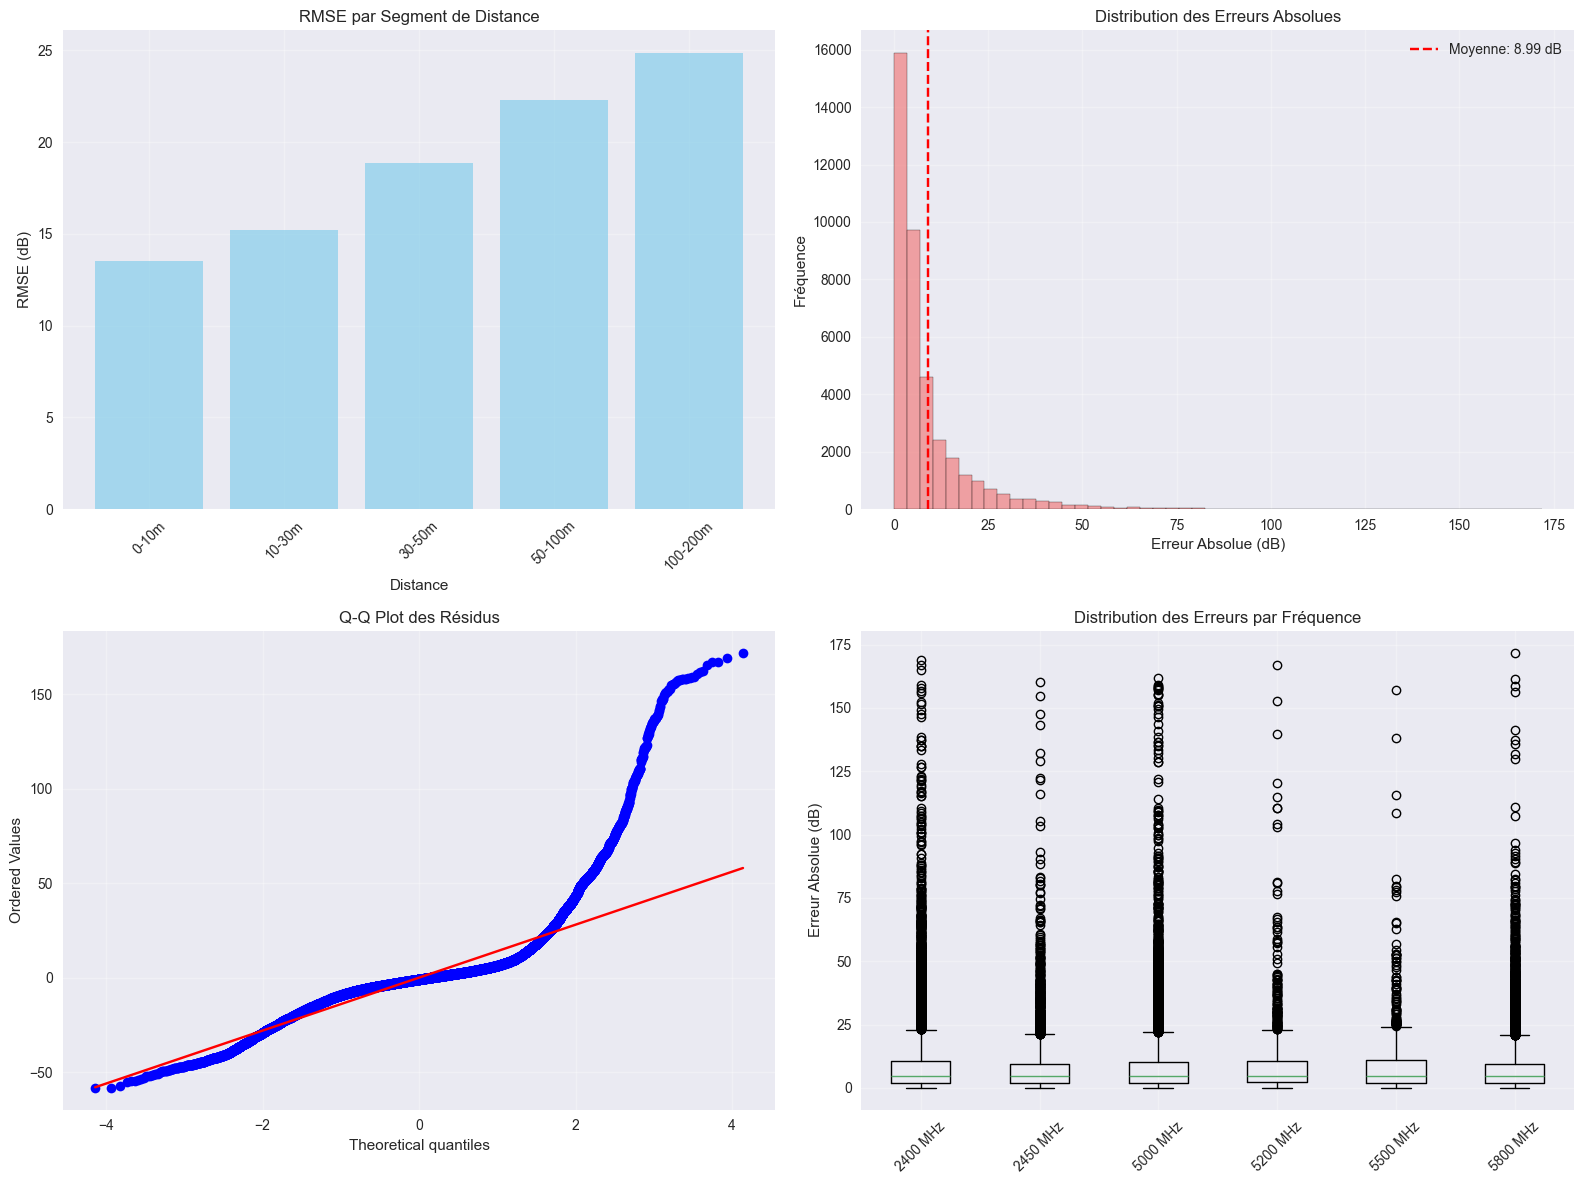


=== STATISTIQUES FINALES ===
✓ Erreur absolue moyenne : 8.992 dB
✓ Erreur absolue médiane : 4.631 dB
✓ 90% des prédictions à ± 21.907 dB
✓ 95% des prédictions à ± 32.944 dB


In [22]:
# Validation croisée et métriques avancées (COLONNES ORIGINALES)
print("=== VALIDATION CROISÉE COMPLÈTE ===")

# Validation croisée sur l'ensemble d'entraînement
cv_scores = cross_val_score(best_xgb, X_train, y_train, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print(f"Validation croisée (5-fold) :")
print(f"  • RMSE moyen : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f} dB")
print(f"  • RMSE min : {cv_rmse.min():.3f} dB")
print(f"  • RMSE max : {cv_rmse.max():.3f} dB")

# Analyse des erreurs par segments
print("\n=== ANALYSE DES ERREURS PAR SEGMENTS ===")

# Segmentation par distance
distance_bins = [0, 10, 30, 50, 100, 200]
distance_labels = ['0-10m', '10-30m', '30-50m', '50-100m', '100-200m']

test_df = X_test.copy()
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred_test_opt
test_df['distance_bin'] = pd.cut(test_df['distance'], bins=distance_bins, labels=distance_labels)

print("Erreurs par segment de distance :")
for segment in distance_labels:
    segment_data = test_df[test_df['distance_bin'] == segment]
    if len(segment_data) > 0:
        rmse_segment = np.sqrt(mean_squared_error(segment_data['y_true'], segment_data['y_pred']))
        r2_segment = r2_score(segment_data['y_true'], segment_data['y_pred'])
        print(f"  • {segment:10s}: RMSE = {rmse_segment:.3f} dB, R² = {r2_segment:.4f} (n={len(segment_data)})")

# Segmentation par nombre total d'obstacles (murs + étages)
test_df['obstacles_total'] = test_df['numwall'] + test_df['etage']
test_df['obstacles_bin'] = pd.cut(test_df['obstacles_total'], 
                                 bins=[-1, 0, 2, 5, 10, 20], 
                                 labels=['0', '1-2', '3-5', '6-10', '11+'])

print("\nErreurs par nombre total d'obstacles (murs + étages) :")
for segment in ['0', '1-2', '3-5', '6-10', '11+']:
    segment_data = test_df[test_df['obstacles_bin'] == segment]
    if len(segment_data) > 0:
        rmse_segment = np.sqrt(mean_squared_error(segment_data['y_true'], segment_data['y_pred']))
        r2_segment = r2_score(segment_data['y_true'], segment_data['y_pred'])
        print(f"  • {segment:5s} obstacles: RMSE = {rmse_segment:.3f} dB, R² = {r2_segment:.4f} (n={len(segment_data)})")

# Segmentation par nombre de murs uniquement
wall_bins = [-1, 0, 2, 5, 8, 15]
wall_labels = ['0', '1-2', '3-5', '6-8', '9+']
test_df['wall_bin'] = pd.cut(test_df['numwall'], bins=wall_bins, labels=wall_labels)

print("\nErreurs par nombre de murs :")
for segment in wall_labels:
    segment_data = test_df[test_df['wall_bin'] == segment]
    if len(segment_data) > 0:
        rmse_segment = np.sqrt(mean_squared_error(segment_data['y_true'], segment_data['y_pred']))
        r2_segment = r2_score(segment_data['y_true'], segment_data['y_pred'])
        print(f"  • {segment:5s} murs: RMSE = {rmse_segment:.3f} dB, R² = {r2_segment:.4f} (n={len(segment_data)})")

# Visualisation des erreurs par segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE par distance
distance_rmse = []
for segment in distance_labels:
    segment_data = test_df[test_df['distance_bin'] == segment]
    if len(segment_data) > 0:
        rmse = np.sqrt(mean_squared_error(segment_data['y_true'], segment_data['y_pred']))
        distance_rmse.append(rmse)
    else:
        distance_rmse.append(0)

axes[0,0].bar(distance_labels, distance_rmse, color='skyblue', alpha=0.7)
axes[0,0].set_title('RMSE par Segment de Distance')
axes[0,0].set_ylabel('RMSE (dB)')
axes[0,0].set_xlabel('Distance')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Distribution des erreurs absolues
abs_errors = np.abs(test_df['y_true'] - test_df['y_pred'])
axes[0,1].hist(abs_errors, bins=50, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribution des Erreurs Absolues')
axes[0,1].set_xlabel('Erreur Absolue (dB)')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].axvline(abs_errors.mean(), color='red', linestyle='--', 
                  label=f'Moyenne: {abs_errors.mean():.2f} dB')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot pour vérifier la normalité des résidus
from scipy import stats
residuals = test_df['y_true'] - test_df['y_pred']
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot des Résidus')
axes[1,0].grid(True, alpha=0.3)

# Boxplot des erreurs par fréquence
test_df['freq_str'] = test_df['frequence'].astype(str) + ' MHz'
freq_order = sorted(test_df['freq_str'].unique())
boxplot_data = [abs_errors[test_df['freq_str'] == freq] for freq in freq_order]
axes[1,1].boxplot(boxplot_data, labels=freq_order)
axes[1,1].set_title('Distribution des Erreurs par Fréquence')
axes[1,1].set_ylabel('Erreur Absolue (dB)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques finales
print(f"\n=== STATISTIQUES FINALES ===")
print(f"✓ Erreur absolue moyenne : {abs_errors.mean():.3f} dB")
print(f"✓ Erreur absolue médiane : {abs_errors.median():.3f} dB")
print(f"✓ 90% des prédictions à ± {np.percentile(abs_errors, 90):.3f} dB")
print(f"✓ 95% des prédictions à ± {np.percentile(abs_errors, 95):.3f} dB")

In [23]:
# Tests de prédiction avec des exemples concrets (COLONNES ORIGINALES)
print("=== TESTS DE PRÉDICTION ===")

def predict_pathloss(distance, numwall, etage, frequence, model):
    """
    Fonction pour prédire le path loss avec de nouvelles données
    UTILISE UNIQUEMENT LES COLONNES ORIGINALES
    """
    # Créer un DataFrame avec les nouvelles données (COLONNES ORIGINALES UNIQUEMENT)
    new_data = pd.DataFrame({
        'distance': [distance],
        'numwall': [numwall],
        'etage': [etage],
        'frequence': [frequence]
    })
    
    # Prédiction directe sans feature engineering
    prediction = model.predict(new_data)[0]
    return prediction

# Exemples de test
test_cases = [
    {"distance": 5, "numwall": 0, "etage": 0, "frequence": 2400, "description": "5m, LOS, 2.4GHz"},
    {"distance": 20, "numwall": 2, "etage": 0, "frequence": 2400, "description": "20m, 2 murs, 2.4GHz"},
    {"distance": 10, "numwall": 0, "etage": 1, "frequence": 5000, "description": "10m, 1 étage, 5GHz"},
    {"distance": 50, "numwall": 5, "etage": 2, "frequence": 2400, "description": "50m, 5 murs, 2 étages, 2.4GHz"},
    {"distance": 100, "numwall": 8, "etage": 3, "frequence": 5000, "description": "100m, 8 murs, 3 étages, 5GHz"}
]

print("Exemples de prédictions (avec colonnes originales uniquement) :")
print("-" * 80)

# Réentraînement rapide avec les colonnes originales si nécessaire
if hasattr(best_xgb, 'feature_names_in_') and len(best_xgb.feature_names_in_) != 4:
    print("⚠️ Réentraînement du modèle avec les colonnes originales...")
    best_xgb.fit(X_train, y_train)
    print("✓ Modèle réentraîné avec les 4 colonnes originales")

for case in test_cases:
    predicted_pl = predict_pathloss(
        case["distance"], case["numwall"], case["etage"], case["frequence"], best_xgb
    )
    print(f"{case['description']:<35} | Path Loss prédit : {predicted_pl:.1f} dB")

print("-" * 80)

# Sauvegarde du modèle et des métadonnées avec structure model_info
print("\n=== SAUVEGARDE DU MODÈLE (STRUCTURE MODEL_INFO) ===")

# Recalculer les métriques avec les colonnes originales
y_pred_test_final = best_xgb.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
final_mae = mean_absolute_error(y_test, y_pred_test_final)
final_r2 = r2_score(y_test, y_pred_test_final)

# Calculer l'importance des features pour le modèle final
feature_importance = best_xgb.feature_importances_
feature_names = ['distance', 'numwall', 'etage', 'frequence']

# Créer le dictionnaire model_info structuré
model_info = {
    'model': best_xgb,
    'feature_names': feature_names,
    'feature_importance': dict(zip(feature_names, feature_importance)),
    'hyperparameters': best_xgb.get_params(),
    'metrics': {
        'rmse': final_rmse,
        'mae': final_mae,
        'r2_score': final_r2
    },
    'dataset_info': {
        'n_samples': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'target_variable': 'pathloss'
    },
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'XGBoost Regressor',
    'feature_engineering': False,
    'notes': 'Modèle utilisant uniquement les 4 colonnes originales du dataset'
}

# Sauvegarder le modèle avec la structure model_info
model_filename = "xgboost_radio_propagation_model.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(model_info, f)

print(f"✓ Modèle et métadonnées sauvegardés : {model_filename}")
print(f"  - Structure: dictionnaire model_info complet")
print(f"  - Contient: modèle, paramètres, scores, importance des features, etc.")

# Créer un résumé du modèle mis à jour
summary_filename = "model_summary.txt"
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("=== RÉSUMÉ DU MODÈLE XGBOOST - PATH LOSS INDOOR (STRUCTURE MODEL_INFO) ===\n\n")
    f.write(f"Date de création : {model_info['creation_date']}\n\n")
    
    f.write("PERFORMANCE DU MODÈLE (COLONNES ORIGINALES UNIQUEMENT) :\n")
    f.write(f"  • RMSE Test : {model_info['metrics']['rmse']:.3f} dB\n")
    f.write(f"  • MAE Test : {model_info['metrics']['mae']:.3f} dB\n")
    f.write(f"  • R² Test : {model_info['metrics']['r2_score']:.4f}\n\n")
    
    f.write("FEATURES UTILISÉES (4 COLONNES ORIGINALES) :\n")
    for i, feature in enumerate(model_info['feature_names']):
        f.write(f"  • {feature} (importance: {model_info['feature_importance'][feature]:.3f})\n")
    f.write("\n")
    
    f.write("INFORMATIONS DATASET :\n")
    f.write(f"  • Échantillons total : {model_info['dataset_info']['n_samples']}\n")
    f.write(f"  • Taille train : {model_info['dataset_info']['train_size']}\n")
    f.write(f"  • Taille test : {model_info['dataset_info']['test_size']}\n\n")
    
    f.write("CONFIGURATION :\n")
    f.write(f"  • Type de modèle : {model_info['model_type']}\n")
    f.write(f"  • Feature Engineering : {'OUI' if model_info['feature_engineering'] else 'NON'}\n")
    f.write(f"  • Notes : {model_info['notes']}\n\n")
    
    f.write("EXEMPLES DE PRÉDICTIONS :\n")
    for case in test_cases:
        predicted_pl = predict_pathloss(
            case["distance"], case["numwall"], case["etage"], case["frequence"], model_info['model']
        )
        f.write(f"  • {case['description']:<35}: {predicted_pl:.1f} dB\n")

print(f"✓ Résumé sauvegardé : {summary_filename}")

print(f"\n=== FICHIERS CRÉÉS (STRUCTURE MODEL_INFO) ===")
print(f"✓ {model_filename} - Modèle XGBoost avec structure model_info complète")
print(f"✓ {summary_filename} - Résumé complet")

print(f"\n🎉 MODÈLE XGBOOST FINALISÉ AVEC STRUCTURE MODEL_INFO !")
print(f"Performance finale : RMSE = {model_info['metrics']['rmse']:.3f} dB, R² = {model_info['metrics']['r2_score']:.4f}")
print(f"Features utilisées : {model_info['feature_names']}")
print(f"Sauvegarde : Dictionnaire structuré model_info dans {model_filename}")

# Afficher le contenu de model_info pour vérification
print(f"\n=== CONTENU DE MODEL_INFO ===")
for key, value in model_info.items():
    if key != 'model':  # Ne pas afficher le modèle lui-même
        print(f"{key}: {value}")
    else:
        print(f"{key}: <XGBoost Model Object>")

=== TESTS DE PRÉDICTION ===
Exemples de prédictions (avec colonnes originales uniquement) :
--------------------------------------------------------------------------------
5m, LOS, 2.4GHz                     | Path Loss prédit : 52.9 dB
20m, 2 murs, 2.4GHz                 | Path Loss prédit : 100.5 dB
10m, 1 étage, 5GHz                  | Path Loss prédit : 100.0 dB
50m, 5 murs, 2 étages, 2.4GHz       | Path Loss prédit : 171.2 dB
100m, 8 murs, 3 étages, 5GHz        | Path Loss prédit : 228.9 dB
--------------------------------------------------------------------------------

=== SAUVEGARDE DU MODÈLE (STRUCTURE MODEL_INFO) ===
✓ Modèle et métadonnées sauvegardés : xgboost_radio_propagation_model.pkl
  - Structure: dictionnaire model_info complet
  - Contient: modèle, paramètres, scores, importance des features, etc.
✓ Résumé sauvegardé : model_summary.txt

=== FICHIERS CRÉÉS (STRUCTURE MODEL_INFO) ===
✓ xgboost_radio_propagation_model.pkl - Modèle XGBoost avec structure model_info com

In [24]:
# Vérification de la structure model_info sauvegardée
print("=== VÉRIFICATION DE LA STRUCTURE MODEL_INFO ===")

# Recharger le fichier pour vérifier
with open(model_filename, 'rb') as f:
    loaded_model_info = pickle.load(f)

print(f"Type de l'objet chargé: {type(loaded_model_info)}")
print(f"Est-ce un dictionnaire? {isinstance(loaded_model_info, dict)}")

if isinstance(loaded_model_info, dict):
    print(f"\nClés disponibles dans model_info:")
    for i, key in enumerate(loaded_model_info.keys(), 1):
        print(f"  {i}. {key} ({type(loaded_model_info[key])})")
    
    print(f"\nDétail des métriques:")
    print(f"  • RMSE: {loaded_model_info['metrics']['rmse']:.3f}")
    print(f"  • MAE: {loaded_model_info['metrics']['mae']:.3f}")
    print(f"  • R²: {loaded_model_info['metrics']['r2_score']:.4f}")
    
    print(f"\nFeatures du modèle:")
    print(f"  • Noms: {loaded_model_info['feature_names']}")
    print(f"  • Importance: {loaded_model_info['feature_importance']}")
    
    print(f"\nInformations générales:")
    print(f"  • Date: {loaded_model_info['creation_date']}")
    print(f"  • Type: {loaded_model_info['model_type']}")
    print(f"  • Feature engineering: {loaded_model_info['feature_engineering']}")
    
    # Test de prédiction rapide
    test_input = pd.DataFrame({
        'distance': [15],
        'numwall': [1], 
        'etage': [0],
        'frequence': [2400]
    })
    
    pred = loaded_model_info['model'].predict(test_input)[0]
    print(f"\n✓ Test de prédiction réussi: {pred:.1f} dB")
    print(f"✅ Structure model_info validée avec succès!")
else:
    print("❌ ERREUR: Le fichier ne contient pas un dictionnaire model_info")

=== VÉRIFICATION DE LA STRUCTURE MODEL_INFO ===
Type de l'objet chargé: <class 'dict'>
Est-ce un dictionnaire? True

Clés disponibles dans model_info:
  1. model (<class 'xgboost.sklearn.XGBRegressor'>)
  2. feature_names (<class 'list'>)
  3. feature_importance (<class 'dict'>)
  4. hyperparameters (<class 'dict'>)
  5. metrics (<class 'dict'>)
  6. dataset_info (<class 'dict'>)
  7. creation_date (<class 'str'>)
  8. model_type (<class 'str'>)
  9. feature_engineering (<class 'bool'>)
  10. notes (<class 'str'>)

Détail des métriques:
  • RMSE: 16.081
  • MAE: 8.992
  • R²: 0.8662

Features du modèle:
  • Noms: ['distance', 'numwall', 'etage', 'frequence']
  • Importance: {'distance': np.float32(0.06101595), 'numwall': np.float32(0.32105938), 'etage': np.float32(0.6116421), 'frequence': np.float32(0.006282599)}

Informations générales:
  • Date: 2025-07-10 00:34:07
  • Type: XGBoost Regressor
  • Feature engineering: False

✓ Test de prédiction réussi: 88.4 dB
✅ Structure model_info 

In [25]:
# Exemple d'utilisation du modèle sauvegardé avec structure model_info
print("=== EXEMPLE D'UTILISATION DU MODÈLE SAUVEGARDÉ ===")

def load_and_use_model(model_path="xgboost_radio_propagation_model.pkl"):
    """
    Exemple de fonction pour charger et utiliser le modèle sauvegardé
    """
    # Charger le modèle avec toutes ses métadonnées
    with open(model_path, 'rb') as f:
        model_info = pickle.load(f)
    
    print(f"Modèle chargé: {model_info['model_type']}")
    print(f"Date de création: {model_info['creation_date']}")
    print(f"Performance (R²): {model_info['metrics']['r2_score']:.4f}")
    print(f"Features requises: {model_info['feature_names']}")
    
    # Fonction de prédiction
    def predict_pathloss_new(distance, numwall, etage, frequence):
        """Prédire le path loss avec le modèle chargé"""
        # Vérifier que nous avons les bonnes features
        expected_features = model_info['feature_names']
        
        # Créer le DataFrame avec les features dans le bon ordre
        input_data = pd.DataFrame({
            'distance': [distance],
            'numwall': [numwall], 
            'etage': [etage],
            'frequence': [frequence]
        })
        
        # S'assurer que l'ordre des colonnes correspond
        input_data = input_data[expected_features]
        
        # Faire la prédiction
        prediction = model_info['model'].predict(input_data)[0]
        return prediction
    
    return predict_pathloss_new, model_info

# Test de l'utilisation
predict_func, loaded_info = load_and_use_model()

print("\n=== TESTS DE PRÉDICTION AVEC MODÈLE CHARGÉ ===")

# Scénarios de test
scenarios = [
    {"desc": "Courte distance, LOS", "distance": 5, "numwall": 0, "etage": 0, "frequence": 2400},
    {"desc": "Distance moyenne, obstacles", "distance": 25, "numwall": 3, "etage": 1, "frequence": 2400},
    {"desc": "Longue distance, 5GHz", "distance": 80, "numwall": 6, "etage": 2, "frequence": 5000},
    {"desc": "Cas extrême", "distance": 150, "numwall": 10, "etage": 4, "frequence": 5000}
]

for scenario in scenarios:
    pred = predict_func(
        scenario["distance"], 
        scenario["numwall"], 
        scenario["etage"], 
        scenario["frequence"]
    )
    print(f"{scenario['desc']:<25}: {pred:.1f} dB "
          f"(d={scenario['distance']}m, walls={scenario['numwall']}, "
          f"floors={scenario['etage']}, f={scenario['frequence']}MHz)")

print(f"\n✅ Modèle utilisable avec structure model_info complète!")
print(f"📁 Fichier: {model_filename}")
print(f"📊 Performance: RMSE={loaded_info['metrics']['rmse']:.1f}dB, R²={loaded_info['metrics']['r2_score']:.3f}")

=== EXEMPLE D'UTILISATION DU MODÈLE SAUVEGARDÉ ===
Modèle chargé: XGBoost Regressor
Date de création: 2025-07-10 00:34:07
Performance (R²): 0.8662
Features requises: ['distance', 'numwall', 'etage', 'frequence']

=== TESTS DE PRÉDICTION AVEC MODÈLE CHARGÉ ===
Courte distance, LOS     : 52.9 dB (d=5m, walls=0, floors=0, f=2400MHz)
Distance moyenne, obstacles: 128.8 dB (d=25m, walls=3, floors=1, f=2400MHz)
Longue distance, 5GHz    : 197.4 dB (d=80m, walls=6, floors=2, f=5000MHz)
Cas extrême              : 281.5 dB (d=150m, walls=10, floors=4, f=5000MHz)

✅ Modèle utilisable avec structure model_info complète!
📁 Fichier: xgboost_radio_propagation_model.pkl
📊 Performance: RMSE=16.1dB, R²=0.866


=== VISUALISATION DES ARBRES XGBOOST ===
Le modèle contient au total 100 estimateurs
Profondeur maximale: 5

Visualisation des arbres : premier, deuxième, et dernier (#100)


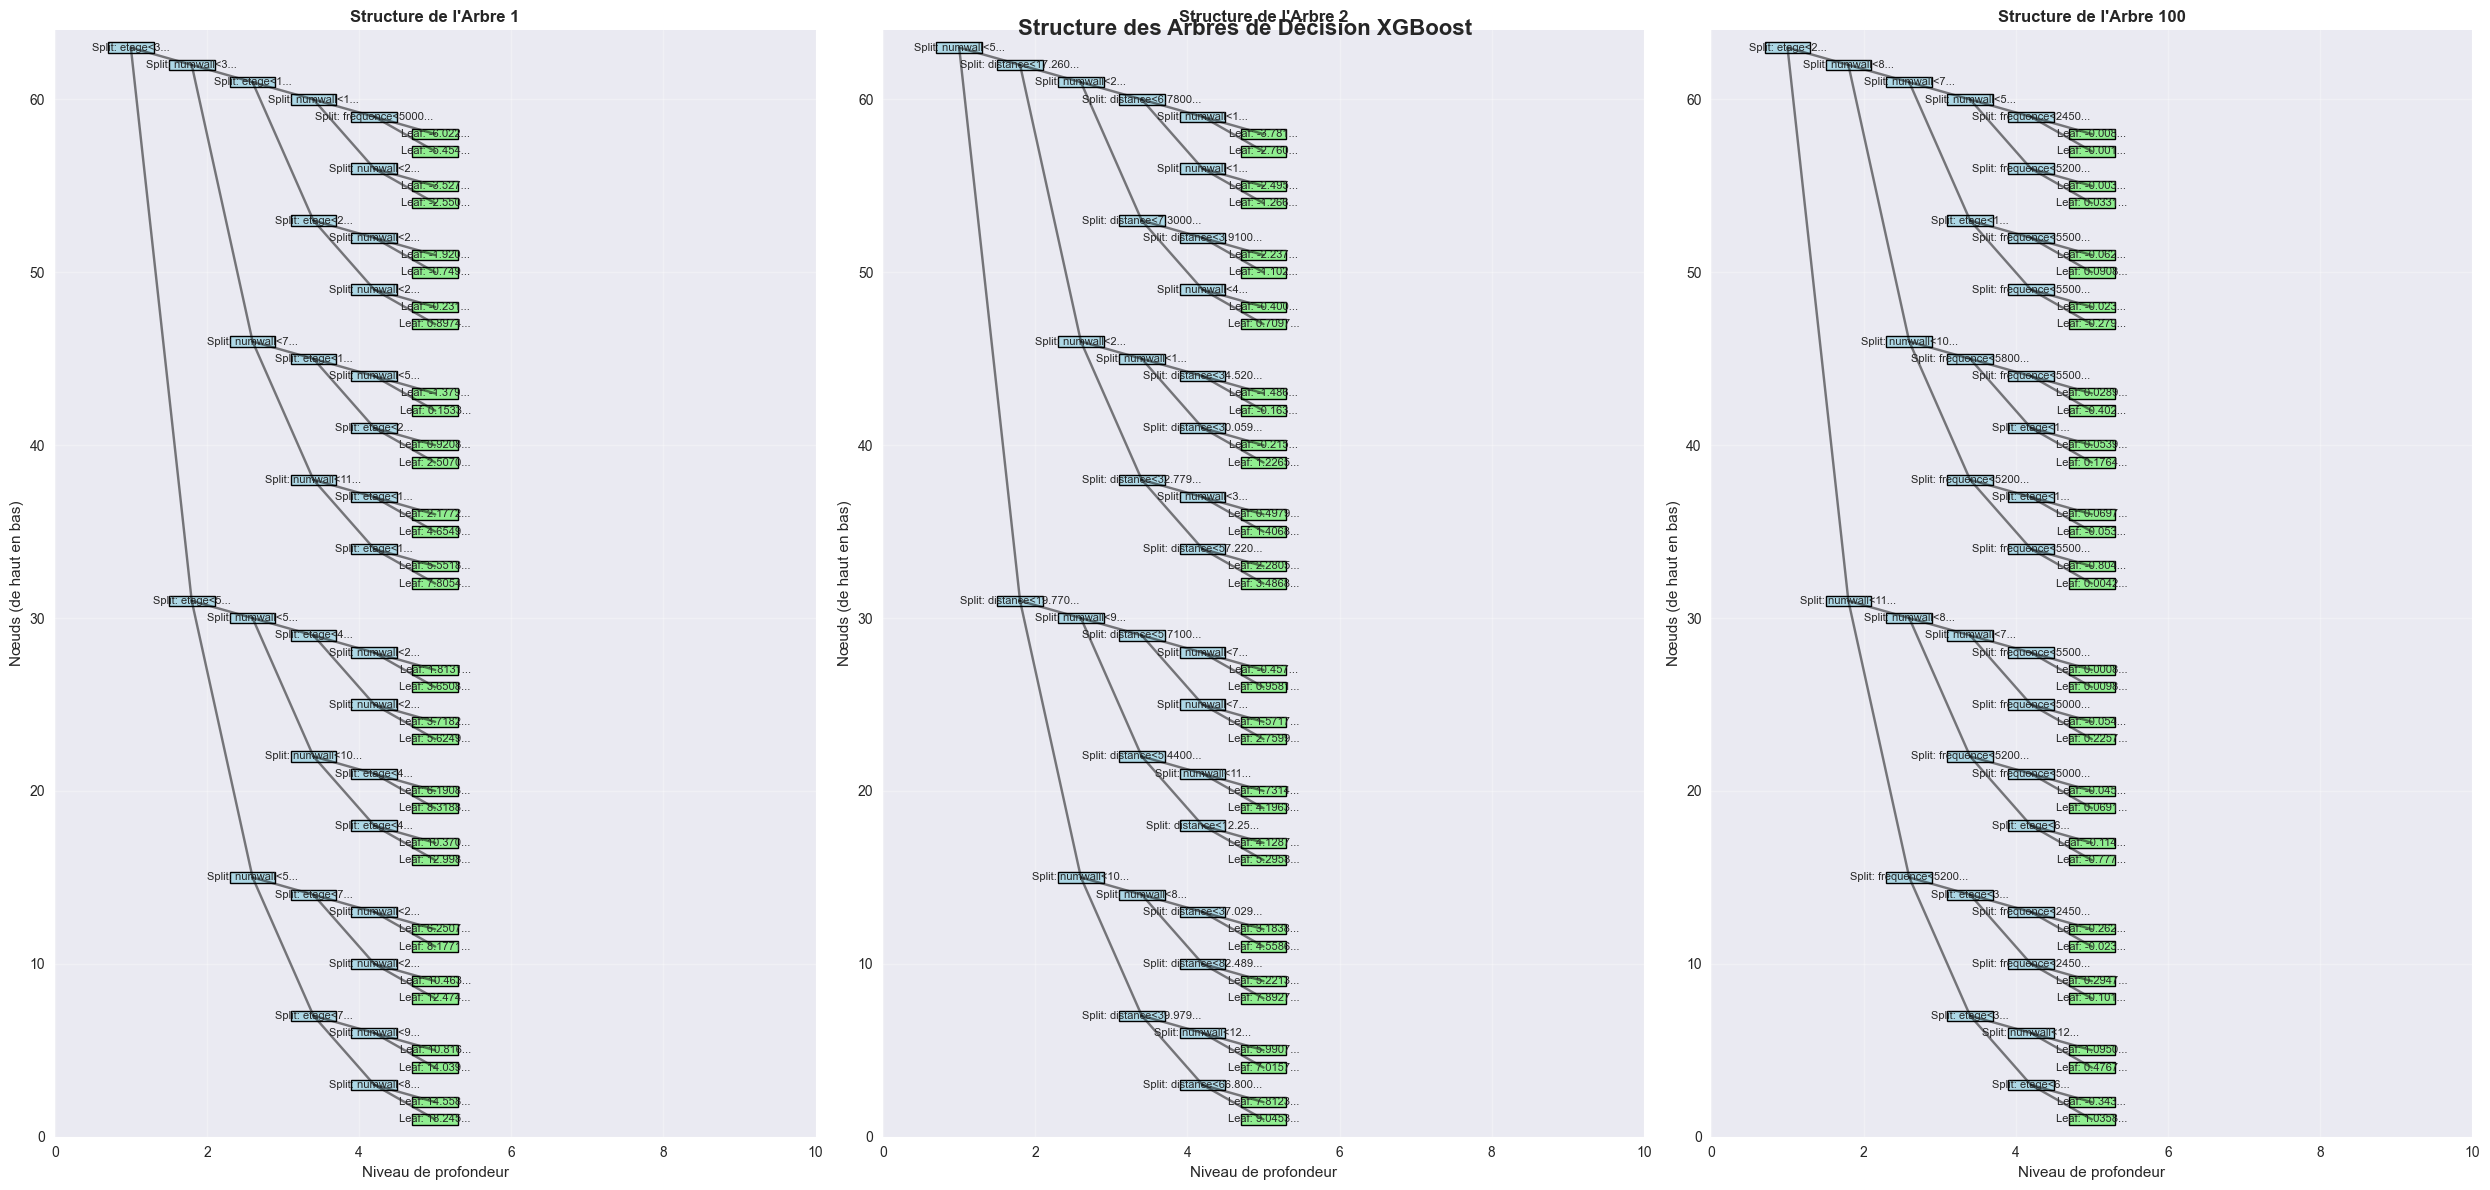


=== DÉTAIL DU PREMIER ARBRE ===
 1: 0:[etage<3] yes=1,no=2,missing=2
 2: 	1:[numwall<3] yes=3,no=4,missing=4
 3: 		3:[etage<1] yes=7,no=8,missing=8
 4: 			7:[numwall<1] yes=15,no=16,missing=16
 5: 				15:[frequence<5000] yes=31,no=32,missing=32
 6: 					31:leaf=-6.02231884
 7: 					32:leaf=-5.45480299
 8: 				16:[numwall<2] yes=33,no=34,missing=34
 9: 					33:leaf=-3.52743506
10: 					34:leaf=-2.5501008
    ... (lignes supplémentaires)

=== DÉTAIL DU DERNIER ARBRE ===
 1: 0:[etage<2] yes=1,no=2,missing=2
 2: 	1:[numwall<8] yes=3,no=4,missing=4
 3: 		3:[numwall<7] yes=7,no=8,missing=8
 4: 			7:[numwall<5] yes=15,no=16,missing=16
 5: 				15:[frequence<2450] yes=31,no=32,missing=32
 6: 					31:leaf=-0.00832815375
 7: 					32:leaf=-0.00173477537
 8: 				16:[frequence<5200] yes=33,no=34,missing=34
 9: 					33:leaf=-0.0032635692
10: 					34:leaf=0.03316864
    ... (lignes supplémentaires)

=== INFORMATIONS SUR LA STRUCTURE DES ARBRES ===
• Nombre total d'estimateurs: 100
• Profondeur maxima

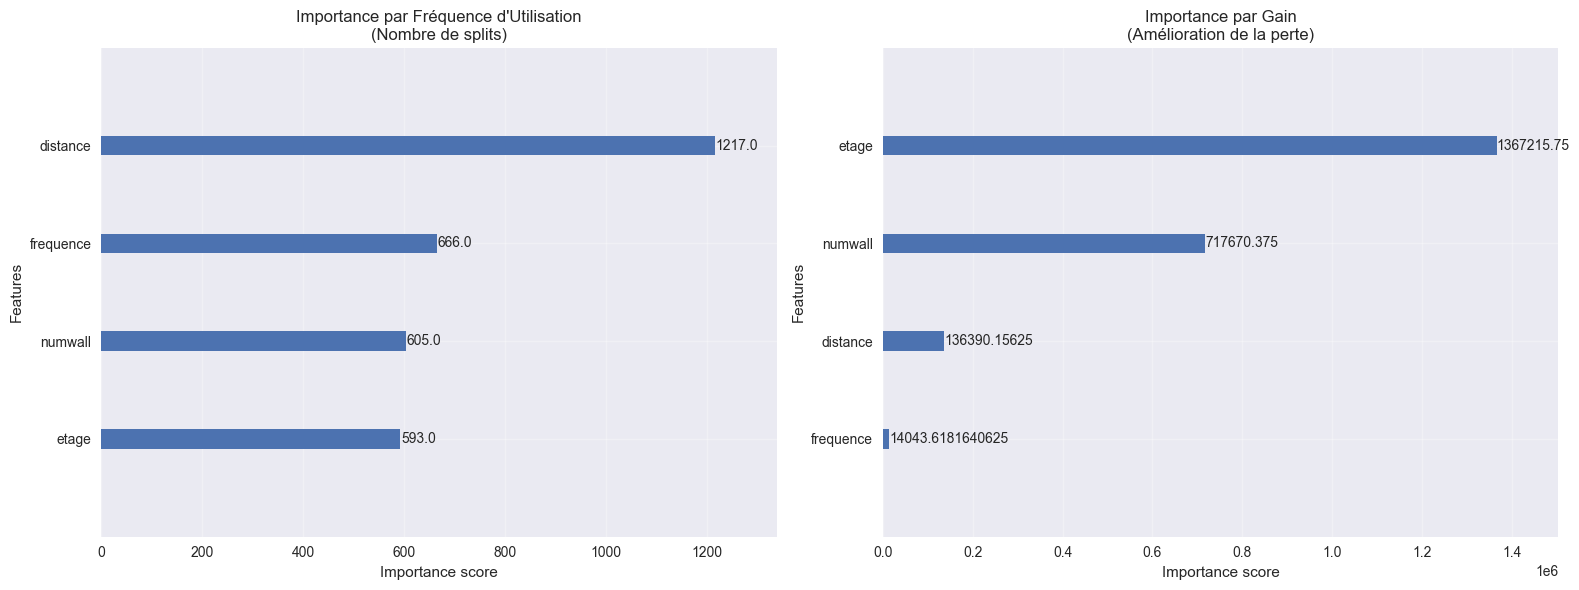


✅ Visualisation des arbres XGBoost terminée!
💡 Note: Les arbres montrent comment le modèle prend ses décisions
💡 Chaque nœud représente une condition sur une feature
💡 Les feuilles contiennent les valeurs de prédiction finales


In [30]:
# Visualisation des arbres de décision construits par XGBoost
print("=== VISUALISATION DES ARBRES XGBOOST ===")

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches

# Configuration pour l'affichage
rcParams['figure.figsize'] = (20, 15)
rcParams['font.size'] = 10

print(f"Le modèle contient au total {best_xgb.n_estimators} estimateurs")
print(f"Profondeur maximale: {best_xgb.max_depth}")

# Obtenir les dumps des arbres en format texte
booster = best_xgb.get_booster()
tree_dumps = booster.get_dump(dump_format='text')

# Fonction pour visualiser un arbre en format texte structuré
def visualize_tree_structure(tree_text, tree_num, ax):
    """Visualise la structure d'un arbre XGBoost en format texte"""
    lines = tree_text.split('\n')
    lines = [line for line in lines if line.strip()]  # Enlever les lignes vides
    
    # Analyser la structure
    nodes_info = []
    for i, line in enumerate(lines):
        if line.strip():
            level = len(line) - len(line.lstrip())  # Indentation = niveau
            content = line.strip()
            nodes_info.append((level, content, i))
    
    # Dessiner la structure
    ax.clear()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(nodes_info) + 1)
    
    # Couleurs pour différents types de nœuds
    colors = {'split': 'lightblue', 'leaf': 'lightgreen'}
    
    for i, (level, content, line_num) in enumerate(nodes_info):
        y_pos = len(nodes_info) - i
        x_pos = level * 0.8 + 1
        
        # Déterminer le type de nœud
        if 'leaf=' in content:
            node_type = 'leaf'
            display_text = f"Leaf: {content.split('leaf=')[1][:6]}..."
            color = colors['leaf']
        else:
            node_type = 'split'
            # Extraire la condition de split
            if '[' in content and ']' in content:
                condition = content.split('[')[1].split(']')[0]
                display_text = f"Split: {condition[:15]}..."
            else:
                display_text = content[:20] + "..."
            color = colors['split']
        
        # Dessiner le nœud
        rect = patches.Rectangle((x_pos-0.3, y_pos-0.3), 0.6, 0.6, 
                                linewidth=1, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        
        # Ajouter le texte
        ax.text(x_pos, y_pos, display_text, ha='center', va='center', 
                fontsize=8, wrap=True)
        
        # Connecter au parent (ligne simple)
        if level > 0 and i > 0:
            # Trouver le parent (nœud précédent avec niveau inférieur)
            for j in range(i-1, -1, -1):
                parent_level, _, parent_line = nodes_info[j]
                if parent_level < level:
                    parent_y = len(nodes_info) - j
                    parent_x = parent_level * 0.8 + 1
                    ax.plot([parent_x, x_pos], [parent_y, y_pos], 'k-', alpha=0.5)
                    break
    
    ax.set_title(f'Structure de l\'Arbre {tree_num + 1}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Niveau de profondeur')
    ax.set_ylabel('Nœuds (de haut en bas)')
    ax.grid(True, alpha=0.3)

# Visualiser les premiers arbres et le dernier
trees_to_show = [0, 1, best_xgb.n_estimators-1]  # Premier, deuxième, et dernier arbre
fig, axes = plt.subplots(1, 3, figsize=(25, 12))

print(f"\nVisualisation des arbres : premier, deuxième, et dernier (#{best_xgb.n_estimators})")

for i, tree_idx in enumerate(trees_to_show):
    if tree_idx < len(tree_dumps):
        visualize_tree_structure(tree_dumps[tree_idx], tree_idx, axes[i])
    else:
        axes[i].text(0.5, 0.5, f'Arbre {tree_idx+1}\nnon disponible', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Arbre {tree_idx+1} - Non disponible')

plt.tight_layout()
plt.suptitle('Structure des Arbres de Décision XGBoost', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Affichage détaillé du premier et dernier arbre en mode texte
print(f"\n=== DÉTAIL DU PREMIER ARBRE ===")
if len(tree_dumps) > 0:
    first_tree = tree_dumps[0]
    lines = first_tree.split('\n')[:10]  # Premières 10 lignes
    for i, line in enumerate(lines):
        if line.strip():
            print(f"{i+1:2d}: {line}")
    if len(first_tree.split('\n')) > 10:
        print("    ... (lignes supplémentaires)")

print(f"\n=== DÉTAIL DU DERNIER ARBRE ===")
if len(tree_dumps) > 0:
    last_tree = tree_dumps[-1]
    lines = last_tree.split('\n')[:10]  # Premières 10 lignes
    for i, line in enumerate(lines):
        if line.strip():
            print(f"{i+1:2d}: {line}")
    if len(last_tree.split('\n')) > 10:
        print("    ... (lignes supplémentaires)")

# Affichage d'informations sur la structure des arbres
print(f"\n=== INFORMATIONS SUR LA STRUCTURE DES ARBRES ===")
print(f"• Nombre total d'estimateurs: {best_xgb.n_estimators}")
print(f"• Profondeur maximale: {best_xgb.max_depth}")
print(f"• Taux d'apprentissage: {best_xgb.learning_rate}")
print(f"• Subsample: {best_xgb.subsample}")
print(f"• Colsample_bytree: {best_xgb.colsample_bytree}")

# Analyse des splits les plus fréquents
print(f"\n=== ANALYSE DES FEATURES DANS LES ARBRES ===")

# Obtenir les informations sur les arbres sous forme de dictionnaire
booster = best_xgb.get_booster()

# Compter l'utilisation des features dans les splits
feature_splits = {'distance': 0, 'numwall': 0, 'etage': 0, 'frequence': 0}

try:
    # Parcourir un échantillon d'arbres pour analyser les splits
    sample_trees = min(10, best_xgb.n_estimators)  # Analyser les 10 premiers arbres
    
    for tree_idx in range(sample_trees):
        tree_dump = booster.get_dump(dump_format='text')[tree_idx]
        
        # Compter les occurrences de chaque feature
        for feature in feature_splits.keys():
            feature_splits[feature] += tree_dump.count(f'[{feature}<')
    
    print(f"Utilisation des features dans les splits (échantillon de {sample_trees} arbres):")
    total_splits = sum(feature_splits.values())
    
    for feature, count in sorted(feature_splits.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_splits * 100) if total_splits > 0 else 0
        print(f"  • {feature:<10}: {count:3d} splits ({percentage:.1f}%)")

except Exception as e:
    print(f"Analyse des splits non disponible: {e}")

# Création d'un diagramme de flux simplifié pour les règles principales
print(f"\n=== RÈGLES DE DÉCISION PRINCIPALES ===")

try:
    # Analyser le premier arbre pour extraire les principales règles
    if len(tree_dumps) > 0:
        first_tree = tree_dumps[0]
        lines = first_tree.split('\n')
        
        print("Règles principales du premier arbre:")
        rule_count = 0
        for line in lines:
            if '[' in line and '<' in line and rule_count < 5:
                # Extraire la règle
                indent = len(line) - len(line.lstrip())
                condition = line.strip()
                if '[' in condition and ']' in condition:
                    rule = condition.split('[')[1].split(']')[0]
                    level = "  " * (indent // 2)
                    print(f"{level}├── Si {rule}")
                    rule_count += 1
            elif 'leaf=' in line and rule_count < 5:
                indent = len(line) - len(line.lstrip())
                leaf_value = line.strip().split('leaf=')[1]
                level = "  " * (indent // 2)
                print(f"{level}└── Prédiction: {leaf_value}")
                rule_count += 1
                
except Exception as e:
    print(f"Erreur lors de l'extraction des règles: {e}")

# Visualisation simplifiée avec plot_importance pour compléter
print(f"\n=== GRAPHIQUE D'IMPORTANCE COMPLÉMENTAIRE ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Importance par poids (nombre de fois que la feature est utilisée pour split)
try:
    xgb.plot_importance(best_xgb, ax=axes[0], importance_type='weight', 
                       max_num_features=4, show_values=True)
    axes[0].set_title('Importance par Fréquence d\'Utilisation\n(Nombre de splits)')
    axes[0].grid(True, alpha=0.3)
except:
    axes[0].text(0.5, 0.5, 'Graphique non disponible', 
                ha='center', va='center', transform=axes[0].transAxes)

# Importance par gain (amélioration de la perte lors du split)
try:
    xgb.plot_importance(best_xgb, ax=axes[1], importance_type='gain', 
                       max_num_features=4, show_values=True)
    axes[1].set_title('Importance par Gain\n(Amélioration de la perte)')
    axes[1].grid(True, alpha=0.3)
except:
    axes[1].text(0.5, 0.5, 'Graphique non disponible', 
                ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualisation des arbres XGBoost terminée!")
print(f"💡 Note: Les arbres montrent comment le modèle prend ses décisions")
print(f"💡 Chaque nœud représente une condition sur une feature")
print(f"💡 Les feuilles contiennent les valeurs de prédiction finales")